In [1]:
import math

import keras
import librosa
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
data = np.load(r'C:\Users\dpetr\Desktop\sxoli\Level 3\Individual\datasets\GTZAN\features.npz')
labels = data['labels']

In [ ]:
mel = data['mel']
mel = np.transpose(mel, (0, 2, 1))
print(mel.shape, mel.dtype, labels.shape, labels.dtype)

In [ ]:
mfcc = data['mfcc']
mfcc = np.transpose(mfcc, (0, 2, 1))
print(mfcc.shape, mfcc.dtype, labels.shape, labels.dtype)

In [ ]:
def prepare_datasets(x, y, test_size, validation_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size, stratify=y_train)
    return x_train, x_test, x_validation, y_train, y_test, y_validation

x_train, x_test, x_validation, y_train, y_test, y_validation = prepare_datasets(mfcc, labels, test_size=1500, validation_size=1500)

In [ ]:
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
x_validation = (x_validation - mean) / std

In [79]:
def build_model(input_shape):
    
    #create model
    model = keras.Sequential()

    model.add(keras.layers.GRU(512, input_shape=input_shape, return_sequences='true', kernel_regularizer=keras.regularizers.l2(0.005), recurrent_regularizer=keras.regularizers.l2(0.005)))

    model.add(keras.layers.GRU(64, kernel_regularizer=keras.regularizers.l2(0.001), recurrent_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) #0.001
    model.add(keras.layers.Dropout(0.55))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [80]:
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.0003) #0.0008 best #0.0003 good #0.0005 best #0.0007 good
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
for layer in model.layers:
    print(layer.trainable_weights, "\n")

[<tf.Variable 'gru_40/gru_cell_40/kernel:0' shape=(40, 1536) dtype=float32, numpy=
array([[-0.01822728, -0.01747594, -0.03265145, ..., -0.00891557,
        -0.05865613, -0.02058678],
       [-0.05735413,  0.02085244,  0.0200226 , ..., -0.01375161,
         0.03279824,  0.03705072],
       [ 0.05822779,  0.05671884,  0.01710489, ..., -0.06061411,
        -0.05720427,  0.03151687],
       ...,
       [-0.02115602,  0.0615104 ,  0.03151828, ...,  0.01327682,
        -0.02459883,  0.05477249],
       [ 0.02094083,  0.04951442,  0.0472624 , ..., -0.03872976,
         0.05933335,  0.04414263],
       [-0.04141309, -0.02672977,  0.05654856, ...,  0.03921646,
         0.03736257,  0.05321221]], dtype=float32)>, <tf.Variable 'gru_40/gru_cell_40/recurrent_kernel:0' shape=(512, 1536) dtype=float32, numpy=
array([[ 0.02869654,  0.02888162,  0.01240791, ...,  0.01978979,
        -0.00420908, -0.00513017],
       [-0.02112242, -0.00204074,  0.01684774, ..., -0.00186376,
        -0.03502792, -0.00633

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_40 (GRU)                (None, 130, 512)          850944    
                                                                 
 gru_41 (GRU)                (None, 64)                110976    
                                                                 
 dense_40 (Dense)            (None, 256)               16640     
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 10)                2570      
                                                                 
Total params: 981,130
Trainable params: 981,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
188/188 [===========================

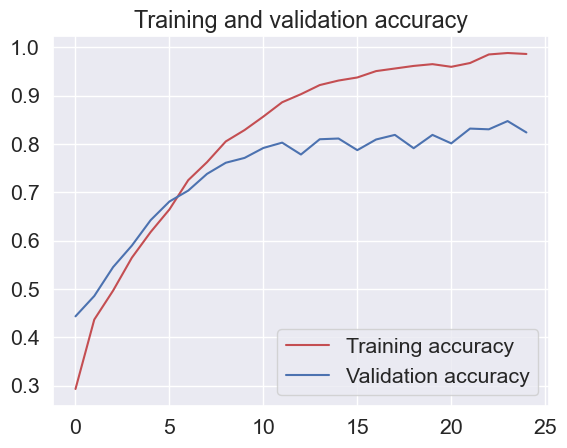

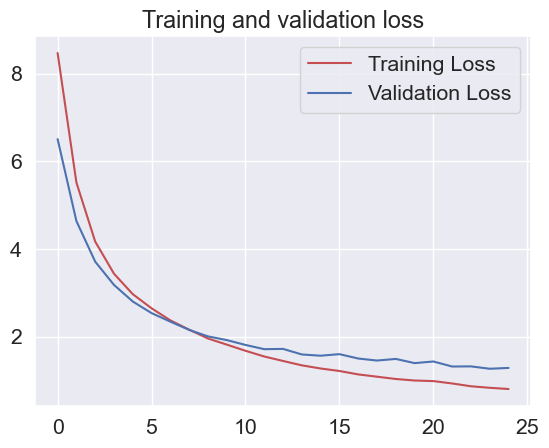

Accuracy on test set is:0.8283283114433289


In [81]:
model.summary()

history = model.fit(x_train, y_train,
          validation_data=(x_validation, y_validation),
          epochs=25,
          batch_size=32
          )

test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("Accuracy on test set is:{}".format(test_accuracy))



In [55]:
predictions = model.predict(x_test, batch_size=32, verbose=1)
predictions

63/63 [==============================] - 2s 11ms/step


array([[9.1274035e-01, 5.2041769e-06, 8.1446409e-02, ..., 1.5880498e-05,
        2.9342703e-04, 3.6566167e-03],
       [1.3789755e-03, 1.0839057e-05, 7.7305056e-05, ..., 6.6023308e-06,
        1.6974349e-05, 9.9662530e-01],
       [3.3214001e-04, 6.0899136e-05, 9.9322480e-01, ..., 3.9414645e-05,
        3.0645879e-03, 2.5941823e-03],
       ...,
       [2.7392321e-06, 1.0229038e-06, 4.7378094e-06, ..., 4.9792243e-07,
        7.7744723e-08, 3.2025142e-04],
       [7.5479870e-04, 3.1381092e-05, 4.6255896e-05, ..., 4.0875631e-04,
        7.3869365e-01, 3.2058542e-04],
       [3.2683325e-04, 1.7726954e-05, 9.9417073e-01, ..., 1.2476123e-03,
        1.1692049e-04, 1.4862875e-03]], dtype=float32)

In [56]:
predicted_indexes = []
for prediction in predictions:
    predicted_indexes.append(np.argmax(prediction))
predicted_indexes

[0,
 9,
 2,
 2,
 2,
 5,
 5,
 5,
 1,
 5,
 1,
 0,
 5,
 1,
 4,
 9,
 6,
 6,
 4,
 8,
 0,
 0,
 2,
 3,
 2,
 1,
 0,
 5,
 8,
 5,
 5,
 1,
 1,
 4,
 3,
 6,
 6,
 7,
 1,
 4,
 2,
 7,
 9,
 4,
 3,
 4,
 5,
 9,
 6,
 4,
 8,
 0,
 8,
 2,
 9,
 1,
 5,
 2,
 3,
 3,
 1,
 5,
 6,
 5,
 4,
 4,
 6,
 1,
 2,
 3,
 0,
 0,
 8,
 2,
 7,
 8,
 3,
 7,
 3,
 0,
 2,
 6,
 2,
 7,
 4,
 6,
 8,
 6,
 3,
 7,
 6,
 3,
 2,
 1,
 2,
 3,
 5,
 8,
 4,
 9,
 2,
 3,
 3,
 6,
 1,
 8,
 5,
 8,
 8,
 2,
 3,
 5,
 9,
 5,
 1,
 1,
 8,
 7,
 5,
 8,
 9,
 3,
 2,
 7,
 6,
 4,
 9,
 5,
 4,
 9,
 0,
 4,
 0,
 1,
 4,
 2,
 9,
 0,
 0,
 3,
 6,
 4,
 9,
 3,
 4,
 2,
 9,
 5,
 7,
 2,
 8,
 8,
 5,
 6,
 1,
 3,
 2,
 1,
 8,
 6,
 7,
 2,
 5,
 0,
 8,
 2,
 6,
 8,
 0,
 0,
 2,
 4,
 9,
 6,
 7,
 9,
 4,
 2,
 0,
 1,
 3,
 3,
 3,
 3,
 3,
 7,
 0,
 1,
 3,
 3,
 1,
 7,
 7,
 3,
 5,
 1,
 6,
 8,
 0,
 8,
 8,
 0,
 7,
 6,
 0,
 4,
 3,
 7,
 9,
 6,
 1,
 4,
 0,
 2,
 2,
 3,
 8,
 3,
 0,
 3,
 0,
 5,
 7,
 6,
 2,
 7,
 2,
 4,
 3,
 1,
 3,
 6,
 0,
 0,
 0,
 0,
 1,
 4,
 5,
 7,
 1,
 9,
 7,
 8,
 3,
 7,
 2,
 1,
 2,
 7,


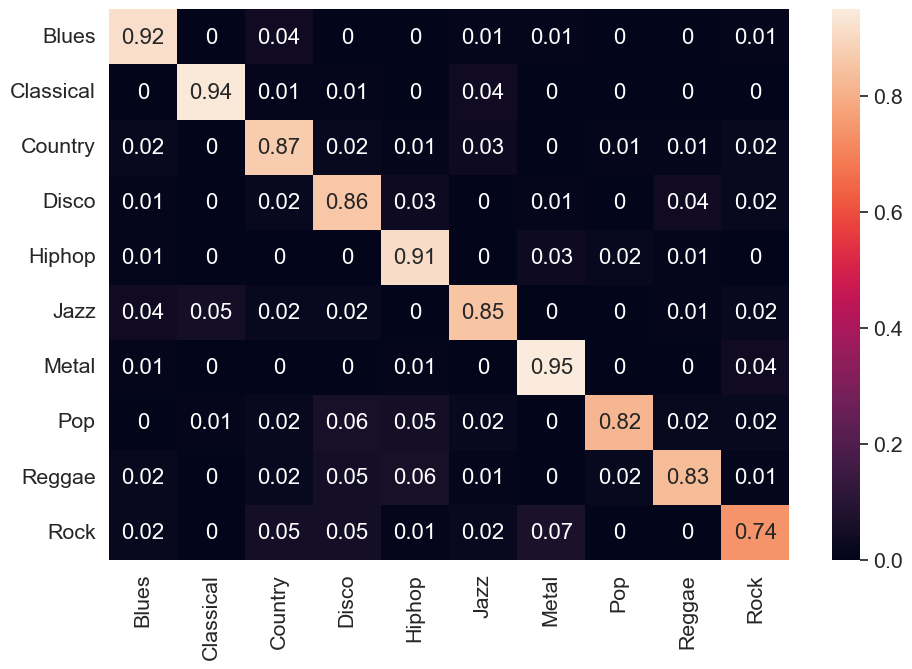

In [72]:
conf_mat = confusion_matrix(y_test, predicted_indexes, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)
plt.figure(figsize = (10,7), dpi = 100)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()


In [58]:
model.save('saved_models/GRU')

INFO:tensorflow:Assets written to: saved_models/GRU\assets


INFO:tensorflow:Assets written to: saved_models/GRU\assets
